# Modelling with local GP experts (Part II): Using the ``LocalExpertOI`` API
In the previous part of the tutorial, we implemented a local GP expert model to fit on non-stationary data. Here, we will do the same except using ``GPSat``'s ``LocalExpertOI`` class, which automates some of the procedures involved making experiments less cumbersome.

In [1]:
import scipy
import os
import GPSat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from GPSat import get_parent_path
from GPSat.postprocessing import glue_local_predictions_1d


2023-08-03 22:09:45.761071: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


We generate the same data as before:

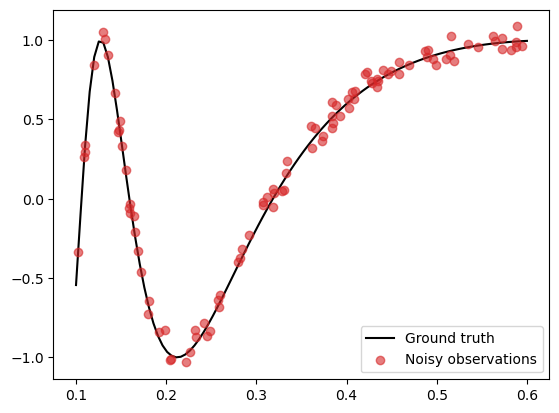

In [2]:
# Set random seed
np.random.seed(0)

# Generate data
N = 100
noise_std = 0.05

X_grid = np.linspace(0.1, 0.6, 100)
X = np.random.uniform(0.1, 0.6, (N,))
f = lambda x: np.sin(1/x)
epsilon = noise_std * np.random.randn(N)

y = f(X) + epsilon
f_truth = f(X_grid) # Ground truth

# Plot
plt.plot(X_grid, f_truth, 'k', zorder=1, label='Ground truth')
plt.scatter(X, y, color='C3', alpha=0.6, zorder=2, label='Noisy observations')
plt.legend()

## Configuration dataclasses

We will now conduct the same experiments as in the previous tutorial using ``GPSat.local_experts.LocalExpertOI``.

First, we break down a single experiment into the following four key components:

1. The local expert locations
2. The GP model assigned to each local expert
3. The training data
4. The points where we want to make predictions

In ``GPSat``, we configure each of these four components with a so-called *configuration dataclass*. The goal is to allow sufficient modelling flexibility to accomodate various problems and datasets.

### 1. Local expert config
We start by setting the configuration for the local expert locations. This can be done by assigning a dataframe containing the locations of the local experts.


In [3]:
from GPSat.config_dataclasses import DataConfig, ModelConfig, PredictionLocsConfig, ExpertLocsConfig

# Construct a data frame containing the two local expert locations
xpert_loc_1 = 0.25
xpert_loc_2 = 0.45
xpert_locs_df = pd.DataFrame({'x': [xpert_loc_1, xpert_loc_2]})

# Set up an expert location configuration dataclass
expert_loc_config = ExpertLocsConfig(source=xpert_locs_df)


The ``source`` argument is where we point to the expert locations. In this case, we simply used a dataframe to represent the expert locations and pointed to that. However in more advanced applications, we also have the functionality to instead point to a file where the expert locations are saved, which can be more convenient.

### 2. Model config
Next, we set up the configuration for the model assigned to each local expert. Here, we will use the ``sklearnGPRModel``, which we specify as follows:

In [4]:
# Set up configuration for the model
model_config = ModelConfig(oi_model="sklearnGPRModel",
                           init_params={"likelihood_variance": noise_std**2,
                                        "kernel": 'RBF',
                                        "verbose": False}
                           )

We specified the model we are using in ``oi_model`` (pre-implemented ``GPSat`` models can be referred to by strings), and in ``init_params``, we pass any arguments used to initialise the model (expressed as a dictionary). Note that we *do not need* to specify arguments to set the data here (namely ``data``, ``coords`` and ``obs``) as this will be done automatically in the main loop.

There are also functionalities to specify constraints on parameters, re-scale the data, etc... however, we will ignore these for the sake of keeping the presentation simple.

### 3. Data config
Next we set up the configuration for data. Here, we configure information such as the source of data and instructions on how to assign a subset of the data to each local expert.

First, we put our training data into a pandas dataframe.

In [5]:
# Write data as dataframe
data_df = pd.DataFrame({'x': X, 'y': y})

data_df.head()


,x,y
0,0.374407,0.395253
1,0.457595,0.862078
2,0.401382,0.628628
3,0.372442,0.364094
4,0.311827,0.009149


For the local data selection, we want to select data points within ± the training radius from the expert locations.

In ``GPSat``, we have a unique API to select data from simple instructions. These instructions are expressed in a dictionary with the keys ``"col"``, ``"comp"`` and ``"val"``. For example, see below for the instructions to select data within ± the inference radius of some reference point.

In [6]:
# Set inference radius
training_radius = 0.15

local_select_instructions = [{"col": "x", "comp": "<=", "val": training_radius},
                             {"col": "x", "comp": ">=", "val": -training_radius}]
                

The first argument ``"col"`` indicates which column in the dataframe we want to impose conditions on (in this case ``"x"``), the ``"comp"`` arguments specifies a relation such as "greater than", "less than", etc... and the ``"val"`` argument specifies the value with which we want to compare our column with (in our case, the training radius).

Thus programmatically, the above list of commands will select data as follows:

```
>>> data_1 = data_df[ (data_df["x"] - ref_point) <= training_radius ]
>>> data_2 = data_df[ (data_df["x"] - ref_point) >= -training_radius ]
>>> local_data = union(data_1, data_2)
```

Here, ``ref_point`` is some reference point, which, in the main loop, will correspond to the expert locations. The command ``union`` is a pseudo-function to take the intersection of members in ``data_1`` and ``data_2``.

With this data selection instruction specified, we can now set the configuration for data as follows.

In [7]:
# Set data config
data_config = DataConfig(data_source = data_df,
                         obs_col = ["y"],
                         coords_col = ["x"],
                         local_select = local_select_instructions
                        )

The argument ``data_source`` points to the dataframe where our data is stored, ``obs_col`` specifies the column in our dataframe corresponding to the measurements, ``coords_col`` specifies the column corresponding to the input coordinates, and ``local_select`` is where we put our instructions for local data selection.

### 4. Prediction location config
Finally, we configure the prediction locations. This should include information about the test locations and the local inference region, where the local experts make predictions. The inference region is simply set to be a circular region around the expert location, with radius given by the inference radius.

First, we write the prediction locations into a dataframe.

In [8]:
# Set up prediction locations as a dataframe
prediction_locs = X_grid
prediction_locs_df = pd.DataFrame({'x': X_grid})

prediction_locs_df.head()


,x
0,0.100000
1,0.105051
2,0.110101
3,0.115152
4,0.120202


We can now set the configuration for prediction locations. We take the inference radius to be slightly larger than the training radius to include predictions on the boundaries.

In [9]:
inference_radius = training_radius + 1e-8

pred_loc_config = PredictionLocsConfig(method = "from_dataframe",
                                       df = prediction_locs_df,
                                       max_dist = inference_radius
                                       )

Here, the ``method`` argument specifies how the prediction locations are selected. In our case this is ``from_dataframe`` and we specify the dataframe in the argument ``df``. The ``max_dist`` argument specifies the inference radius around the expert location.

## Run experiment
We are now in shape to run our experiment. To do this, we initialise a ``LocalExpertOI`` object from the four config classes we created.

In [10]:
from GPSat.local_experts import LocalExpertOI

# Set up local expert experiment
locexp = LocalExpertOI(data_config = data_config,
                       model_config = model_config,
                       expert_loc_config = expert_loc_config,
                       pred_loc_config = pred_loc_config)
                       

'data_select': 0.001 seconds
'load': 0.002 seconds


Now, we just need to specify a path where we want to store our results and run an experiment with the ``run()`` method. The stored path should be a HDF5 file, which uses the extension `".h5"`.

In [11]:
# path to store results
store_path = get_parent_path("results", "1d_tutorial_example.h5")

# for the purposes of a simple example, if store_path exists: delete it
if os.path.exists(store_path):
    os.remove(store_path)
    
# run local expert optimal interpolation
locexp.run(store_path=store_path)

---------
storing expert locations in 'expert_locs' table
exception occurred: 'No object named expert_locs in the file'
will now close object

---------
dropping expert locations that already exists in 'run_details' table
exception occurred: 'No object named run_details in the file'
will now close object

------------------------------
1 / 2
      x
0  0.25
'_max_dist_bool': 0.000 seconds
'_from_dataframe': 0.001 seconds
'data_select': 0.000 seconds
'load': 0.000 seconds
'_update_global_data': 0.000 seconds
'local_data_select': 0.001 seconds
number obs: 62
'__init__': 0.037 seconds
'get_parameters': 0.000 seconds
'optimise_parameters': 0.066 seconds
'get_objective_function_value': 0.000 seconds
'get_parameters': 0.000 seconds
parameters:
lengthscales: 0.0321035488284147
kernel_variance: 0.6388633229513591
likelihood_variance: 0.0025000000000000005
'predict': 0.001 seconds
total run time : 0.39 seconds
------------------------------
2 / 2
      x
1  0.45
'_max_dist_bool': 0.000 seconds


We can extract the results from the HDF5 with the ``local_experts.get_results_from_h5file()`` method.

In [12]:
# extract, store in dict
dfs, _ = GPSat.local_experts.get_results_from_h5file(store_path)

reading in results
getting all tables
'data_select': 0.001 seconds
'load': 0.001 seconds
merging on expert location data
table: 'oi_config' does not have all coords_col: ['x'] in columns, not merging on expert_locations


Check the results that are stored by accessing the keys of the dictionary ``dfs``:

In [13]:
dfs.keys()

dict_keys(['kernel_variance', 'lengthscales', 'likelihood_variance', 'oi_config', 'preds', 'run_details'])

We see tables storing the model parameters (``'kernel_variance'``, ``'lengthscales'``, ``'likelihood_variance'``), the full configuration used to run the experiment stored in json format (``'oi_config'``), model predictions (``'preds'``) and details of the experiment run such as run time, device name, etc... (``'run_details'``).

Let's check the ``'preds'`` table storing the model predictions.

In [14]:
dfs['preds'].head()

,x,_dim_0,f*,f*_var,pred_loc_x
0,0.25,0,-0.501423,0.003268,0.100000
1,0.25,1,-0.080115,0.000920,0.105051
2,0.25,2,0.310646,0.000572,0.110101
3,0.25,3,0.635114,0.000698,0.115152
4,0.25,4,0.866515,0.000760,0.120202


As in the previous tutorial, we can glue overlapping predictions from different experts by running the ``glue_local_predictions_1d()`` method.

In [15]:
glued_preds = glue_local_predictions_1d(preds_df = dfs['preds'],
                                        pred_loc_col = 'pred_loc_x',
                                        xprt_loc_col = 'x',
                                        vars_to_glue = ['f*', 'f*_var'],
                                        inference_radius = inference_radius)
glued_preds.head()

,pred_loc_x,f*,f*_var
0,0.100000,-0.501423,0.003268
1,0.105051,-0.080115,0.000920
2,0.110101,0.310646,0.000572
3,0.115152,0.635114,0.000698
4,0.120202,0.866515,0.000760


We plot the results below

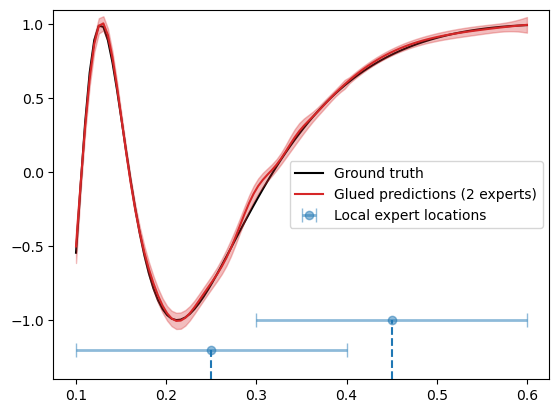

In [21]:
# Extract glued mean and variance predictions
f_mean = glued_preds['f*']
f_var = glued_preds['f*_var']
f_std = np.sqrt(f_var)
X_test = glued_preds['pred_loc_x']

# Plot results
plt.plot(X_grid, f_truth, 'k', zorder=0, label='Ground truth')
plt.plot(X_test, f_mean, color='C3', zorder=1, label='Glued predictions (2 experts)')
plt.fill_between(X_test, f_mean-1.96*f_std, f_mean+1.96*f_std, color='C3', alpha=0.3)

xvals = [0.25, 0.45]
yvals = [-1.2, -1.]
plt.errorbar(xvals, yvals, xerr=0.15, fmt='o', elinewidth=2, barsabove=True, capsize=5, alpha=0.5, label='Local expert locations')
for (x, y) in zip(xvals, yvals):
    plt.vlines(x, -1.4, y, linestyles='dashed')
ax = plt.gca()
ax.set_ylim([-1.4, 1.1])

plt.legend()

In the above, we have also illustrated the local expert locations (blue circle) and the inference regions (blue horizontal bars).

Below, we assess the performance of the model.

In [22]:
print(f"Mean squared error: {np.mean((f_truth - f_mean)**2):.4f}")
print(f"Mean log likelihood: {scipy.stats.norm.logpdf(f_truth, f_mean, f_std).mean():.4f}")

Mean squared error: 0.0005
Mean log likelihood: 2.5734


## Using more local experts
Finally, let's see what happens when we double the number of local experts. Below, we set up the configurations for an experiment using the expert locations at x = [0.2, 0.3, 0.4, 0.5] and training radius = 0.1.

In [25]:
# Set new expert locations
xprt_locs = [0.2, 0.3, 0.4, 0.5]

# Set training and inference radii
training_radius = 0.1
inference_radius = training_radius + 1e-8

# Set up configs
expert_loc_config = ExpertLocsConfig(source=pd.DataFrame({'x': xprt_locs}))

model_config = ModelConfig(oi_model="sklearnGPRModel",
                           init_params={"likelihood_variance": noise_std**2,
                                        "kernel": 'RBF',
                                        "verbose": False}
                           )

data_config = DataConfig(data_source=data_df,
                         obs_col=["y"],
                         coords_col=["x"],
                         local_select=[{"col": "x", "comp": "<=", "val": training_radius},
                                       {"col": "x", "comp": ">=", "val": -training_radius}]
                        )

pred_loc_config = PredictionLocsConfig(method="from_dataframe",
                                       df=prediction_locs_df,
                                       max_dist=inference_radius
                                       )

We run this experiment below using ``LocalExpertOI``.

In [26]:
# Set up local expert experiment
locexp = LocalExpertOI(data_config = data_config,
                       model_config = model_config,
                       expert_loc_config = expert_loc_config,
                       pred_loc_config = pred_loc_config)

# path to store results
store_path = get_parent_path("results", "1d_tutorial_example.h5")

# for the purposes of a simple example, if store_path exists: delete it
if os.path.exists(store_path):
    os.remove(store_path)
    
# run local expert optimal interpolation
locexp.run(store_path=store_path, store_every=1)

'data_select': 0.001 seconds
'load': 0.002 seconds
---------
storing expert locations in 'expert_locs' table
exception occurred: 'No object named expert_locs in the file'
will now close object

---------
dropping expert locations that already exists in 'run_details' table
exception occurred: 'No object named run_details in the file'
will now close object

------------------------------
1 / 4
     x
0  0.2
'_max_dist_bool': 0.000 seconds
'_from_dataframe': 0.000 seconds
'data_select': 0.000 seconds
'load': 0.000 seconds
'_update_global_data': 0.000 seconds
'local_data_select': 0.001 seconds
number obs: 41
'__init__': 0.023 seconds
'get_parameters': 0.000 seconds
'optimise_parameters': 0.172 seconds
'get_objective_function_value': 0.000 seconds
'get_parameters': 0.000 seconds
parameters:
lengthscales: 0.03354575999266631
kernel_variance: 1.536162773874243
likelihood_variance: 0.0025000000000000005
'predict': 0.023 seconds
SAVING RESULTS
run_details
preds
lengthscales
kernel_variance
like

Plot results:

reading in results
getting all tables
'data_select': 0.001 seconds
'load': 0.001 seconds
merging on expert location data
table: 'oi_config' does not have all coords_col: ['x'] in columns, not merging on expert_locations


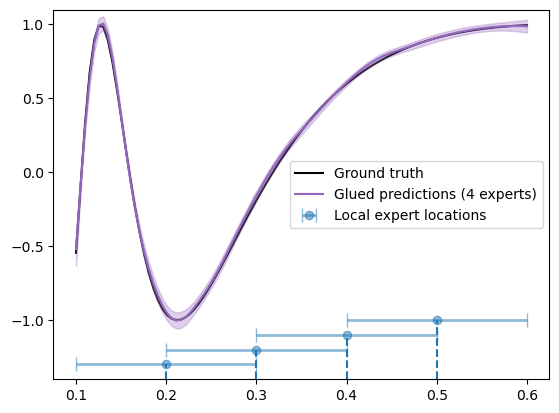

In [27]:
# extract, store in dict
dfs, _ = GPSat.local_experts.get_results_from_h5file(store_path)

glued_preds = glue_local_predictions_1d(preds_df = dfs['preds'],
                                        pred_loc_col = 'pred_loc_x',
                                        xprt_loc_col = 'x',
                                        vars_to_glue = ['f*', 'f*_var'],
                                        inference_radius = inference_radius)

# Extract glued mean and variance predictions
f_mean = glued_preds['f*']
f_var = glued_preds['f*_var']
f_std = np.sqrt(f_var)
X_test = glued_preds['pred_loc_x']

# Plot results
plt.plot(X_grid, f_truth, 'k', zorder=0, label='Ground truth')
plt.plot(X_test, f_mean, color='C4', zorder=1, label='Glued predictions (4 experts)')
plt.fill_between(X_test, f_mean-1.96*f_std, f_mean+1.96*f_std, color='C4', alpha=0.3)

xvals = [0.2, 0.3, 0.4, 0.5]
yvals = [-1.3, -1.2, -1.1, -1.]
plt.errorbar(xvals, yvals, xerr=0.1, fmt='o', elinewidth=2, barsabove=True, capsize=5, alpha=0.5, label='Local expert locations')
for (x, y) in zip(xvals, yvals):
    plt.vlines(x, -1.4, y, linestyles='dashed')
ax = plt.gca()
ax.set_ylim([-1.4, 1.1])

plt.legend()

We see that the results look much better and this is also reflected in the metrics:

In [28]:
print(f"Mean squared error: {np.mean((f_truth - f_mean)**2):.4f}")
print(f"Mean log likelihood: {scipy.stats.norm.logpdf(f_truth, f_mean, f_std).mean():.4f}")

Mean squared error: 0.0003
Mean log likelihood: 2.7179


**Note:** To achieve the best performance using local experts model, each local experts should have sufficiently many data points to prevent overfitting on a particular region. However, if this happens, we can prevent this by *hyperparameter smoothing*.

**Note:** In ``GPSat``, we have not yet considered learning the optimal distribution of expert locations and the corresponding inference/training radii that best fit the data. We typically assume the expert locations to be distributed on an even grid and use the same inference/training at every expert locations. However it might be interesting in the future to consider the learning of such hyperparameters to further improve performance.
